In [1]:
import torch 
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from train import train
from torch.optim import Adam
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Ammount of objects already turned to categorical format, so:
0 -  means no objects 
1 - means 1-5 objects (few)
2 - means 6-10 (some)
3 - means >10 objects (a lot)

Ammount of avalailable weapons means:
0 - no amunition of this type (0)
1 - a few amunition of this type (<10)
2 - some amunition of this type (10-50)
3 - enought amunition of this type (<50)

All of above ammounts could be changed so for example 1 as a detectes combat vehicle could mean not 1-5 but 1-3 detected objects. It will be realized in following code part.


Descisions are also turned into categorical format:
0 - means to use cluster shells 
1 - means to use unitar shells 
2 - means to use FPV kamikaze-drones
3 - means to use machine guns


In [3]:
data = pd.read_csv("/Users/maxkucher/shelling /troops_data.csv", index_col=False)
data = data.drop("Unnamed: 0", axis='columns')
data

,troops_ammount,clusster_shells_ammount,unitar_shells_ammount,fpv_ammount,descision
0,1,0,0,0,3
1,1,0,0,1,3
2,1,0,0,2,3
3,1,0,0,3,2
4,1,0,1,0,3
...,...,...,...,...,...
187,3,3,2,3,0
188,3,3,3,0,0
189,3,3,3,1,0
190,3,3,3,2,0


In [61]:
data = pd.concat([data, data], axis='rows')
data

,troops_ammount,clusster_shells_ammount,unitar_shells_ammount,fpv_ammount,descision
0,1,0,0,0,3
1,1,0,0,1,3
2,1,0,0,2,3
3,1,0,0,3,2
4,1,0,1,0,3
...,...,...,...,...,...
187,3,3,2,3,0
188,3,3,3,0,0
189,3,3,3,1,0
190,3,3,3,2,0


In [62]:
x = data.drop("descision", axis="columns")
y = data["descision"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [63]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x.values)
        self.y = torch.LongTensor(y.values)
        # self.y = self.y.reshape(-1, 1)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [64]:
train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)

In [65]:
len(train_dataset), len(test_dataset)

(307, 77)

In [66]:
x_train.shape

(307, 4)

In [67]:
y_train.value_counts()

descision
0    96
3    91
2    66
1    54
Name: count, dtype: int64

In [68]:
train_dataset[3]

(tensor([2., 0., 1., 0.]), tensor(3))

In [69]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))


In [96]:
class TroopsModel(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.linear1 = nn.Linear(in_features=4, out_features=24)
        self.bnorm1 = nn.BatchNorm1d(24)
        self.linear2 = nn.Linear(in_features=24, out_features=24)
        self.drop1 = nn.Dropout(0.2)
        self.linear3 = nn.Linear(in_features=24, out_features=24)
        self.linear4 = nn.Linear(in_features=24, out_features=12)
        self.linear5 = nn.Linear(in_features=12, out_features=6)
        self.linear6 = nn.Linear(in_features=6, out_features=num_classes)

    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.bnorm1(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.drop1(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        out = F.relu(out)
        out = self.linear6(out)
        return out
    
    def predict(self, x):
        x = torch.FloatTensor(x).to(device)
        with torch.no_grad():
            y_pred = F.softmax(self.forward(x), dim=-1)

        return y_pred
    
model = TroopsModel().to(device)
model

TroopsModel(
  (linear1): Linear(in_features=4, out_features=24, bias=True)
  (bnorm1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=24, out_features=24, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=24, out_features=24, bias=True)
  (linear4): Linear(in_features=24, out_features=12, bias=True)
  (linear5): Linear(in_features=12, out_features=6, bias=True)
  (linear6): Linear(in_features=6, out_features=4, bias=True)
)

In [13]:
%pip install -q torchsummary

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [90]:
from torchsummary import summary

summary(model, input_size=(4, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 24]             120
       BatchNorm1d-2                   [-1, 24]              48
            Linear-3                   [-1, 24]             600
           Dropout-4                   [-1, 24]               0
            Linear-5                   [-1, 24]             600
            Linear-6                   [-1, 12]             300
            Linear-7                    [-1, 6]              78
            Linear-8                    [-1, 4]              28
Total params: 1,774
Trainable params: 1,774
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [97]:
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [98]:
history = train(model, optimizer, loss_func, train_dataloader, test_dataloader, epochs=600, metrics=[accuracy_score], 
                device=device, task="multiclass")

Epoch    1    0sec	loss:       1.36	val_loss:       1.36	accuracy_score:      0.313	val_accuracy_score:      0.312	
Epoch    2    0sec	loss:       1.35	val_loss:       1.35	accuracy_score:      0.313	val_accuracy_score:      0.312	
Epoch    3    0sec	loss:       1.32	val_loss:       1.33	accuracy_score:      0.313	val_accuracy_score:      0.312	
Epoch    4    0sec	loss:        1.3	val_loss:        1.3	accuracy_score:      0.329	val_accuracy_score:      0.364	
Epoch    5    0sec	loss:       1.26	val_loss:       1.26	accuracy_score:      0.388	val_accuracy_score:       0.39	
Epoch    6    0sec	loss:       1.21	val_loss:       1.21	accuracy_score:      0.446	val_accuracy_score:      0.416	
Epoch    7    0sec	loss:       1.15	val_loss:       1.15	accuracy_score:      0.534	val_accuracy_score:      0.532	
Epoch    8    0sec	loss:       1.08	val_loss:       1.09	accuracy_score:      0.547	val_accuracy_score:      0.532	
Epoch    9    0sec	loss:          1	val_loss:       1.02	accuracy_score:

In [99]:
loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

predicted_classes = torch.argmax(y_pred, dim=1).cpu().numpy()

print(predicted_classes)


[2 0 3 0 0 0 3 2 0 2 0 0 0 2 3 1 3 0 0 2 0 2 3 3 2 1 0 1 0 1 2 1 3 3 1 3 3
 2 3 1 3 3 3 0 3 1 0 0 2 3 1 0 0 2 3 3 0 2 3 2 1 3 0 0 1 2 0 1 2 0 1 1 3 0
 3 1 3]


In [100]:
len(y_test)

77

[]

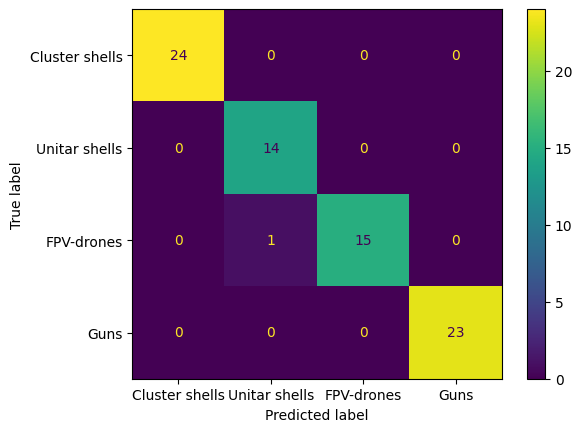

In [101]:
commands = ["Cluster shells", "Unitar shells", "FPV-drones", "Guns"]

ConfusionMatrixDisplay.from_predictions(y_test, predicted_classes, display_labels=commands)
plt.plot()

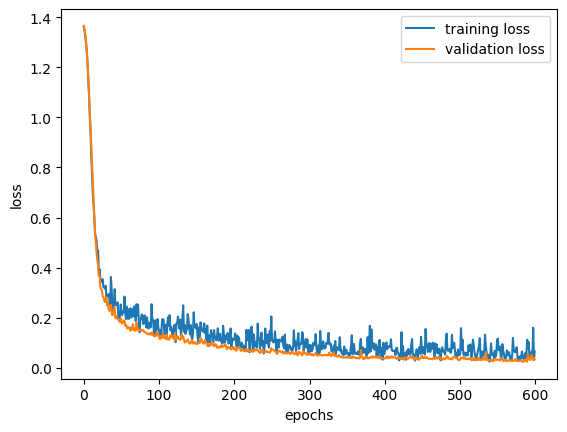

In [102]:
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [103]:
# data[data["descision"] == 3] 

In [104]:
import torch

commands = ["Cluster shells", "Unitar shells", "FPV-drones", "Guns"]

x = torch.FloatTensor([3, 0, 0, 0]).to(device)
x = x.unsqueeze(0)
model.eval()

with torch.no_grad():
    res = model(x)

t_x = torch.argmax(res)
t_array = np.array(t_x)


print(commands[t_array])


Guns


In [105]:
torch.save(model, "troops.pt")

In [107]:
m = torch.load("/Users/maxkucher/shelling /troops.pt")

In [109]:
summary(m, input_size=(4,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 24]             120
       BatchNorm1d-2                   [-1, 24]              48
            Linear-3                   [-1, 24]             600
           Dropout-4                   [-1, 24]               0
            Linear-5                   [-1, 24]             600
            Linear-6                   [-1, 12]             300
            Linear-7                    [-1, 6]              78
            Linear-8                    [-1, 4]              28
Total params: 1,774
Trainable params: 1,774
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [ ]:
torch.save(model.state_dict(), "troops.pt")